# Random Forest

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix,recall_score
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
import random

In [50]:
random_seed = 100
random.seed(random_seed)
np.random.seed(random_seed)

df = pd.read_csv("../dataset/aps_failure_training_set.csv")
df_test = pd.read_csv("../dataset/aps_failure_test_set.csv")

In [51]:
df.head()


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


### Renombrar valores de la columna objetivo. Mapear los valores na to NULL

In [52]:
df = df.rename(columns = {'class' : 'Flag'})
df['Flag'] = df.Flag.map({'neg':0, 'pos':1})
df = df.replace(['na'],[np.NaN])

### Verificar los datos actualizados

In [53]:
df.isnull().any().head(25)


Flag      False
aa_000    False
ab_000     True
ac_000     True
ad_000     True
ae_000     True
af_000     True
ag_000     True
ag_001     True
ag_002     True
ag_003     True
ag_004     True
ag_005     True
ag_006     True
ag_007     True
ag_008     True
ag_009     True
ah_000     True
ai_000     True
aj_000     True
ak_000     True
al_000     True
am_0       True
an_000     True
ao_000     True
dtype: bool

Text(0,0.5,'Frecuencia')

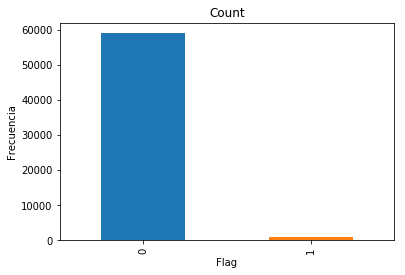

In [54]:
# Verificar la distribucion de la columna clase

Count = pd.value_counts(df['Flag'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Count")
plt.xlabel("Flag")
plt.ylabel("Frecuencia")

#### La data esta muy imbalanceada, se aplicara PCA para mejorar el performance del os modelos. Los valores faltantes se completaran con la media.

In [55]:
df_X = df.loc[:,df.columns != 'Flag']
df_Y = df.loc[:,df.columns == 'Flag']

df_X = df_X.apply(pd.to_numeric)

df_X= df_X.fillna(df_X.mean()).dropna(axis =1 , how ='all')

scaler = StandardScaler()

scaler.fit(df_X)

df_X = scaler.transform(df_X)

pca = PCA(0.95)

pca.fit(df_X)

#Numero de componentes se redujo
pca.n_components_

82

#### Transformar la data

In [56]:
df_X = pca.transform(df_X)

df_X= pd.DataFrame(df_X)

### Aplicar lo mismo a los otros Set de data

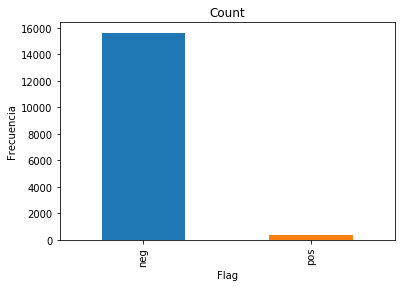

In [57]:
df_test = df_test.rename(columns = {'class' : 'Flag'})
df_test = df_test.replace(['na'],[np.NaN])

Count = pd.value_counts(df_test['Flag'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Count")
plt.xlabel("Flag")
plt.ylabel("Frecuencia")

df_test['Flag'] = df_test.Flag.map({'neg':0, 'pos':1})

df_test_X = df_test.loc[:,df_test.columns != 'Flag']
df_test_Y = df_test.loc[:,df_test.columns == 'Flag']

df_test_X = df_test_X.apply(pd.to_numeric)

df_test_X= df_test_X.fillna(df_test_X.mean()).dropna(axis =1 , how ='all')

scaler = StandardScaler()

scaler.fit(df_test_X)

df_test_X = scaler.transform(df_test_X)

pca = PCA(82)

pca.fit(df_test_X)

pca.n_components_

df_test_X = pca.transform(df_test_X)

df_test_X= pd.DataFrame(df_test_X)

In [58]:
X_train,X_validation,Y_train,Y_validation = train_test_split(df_X,df_Y,test_size = 0.2,random_state = 0)
DF = pd.concat([X_train,Y_train],axis = 1)

### Se aplicara undersampling para balancear los datos

In [59]:
numberofrecords_pos = len(DF[DF.Flag == 1])
pos_indices = np.array(DF[DF.Flag == 1].index)

neg_indices = DF[DF.Flag == 0].index

random_neg_indices = np.random.choice(neg_indices, numberofrecords_pos, replace = False)
random_neg_indices =np.array(random_neg_indices)

under_sample_indices = np.concatenate([pos_indices,random_neg_indices])

under_sample_data = DF.loc[under_sample_indices,:]

X_undersample = under_sample_data.loc[:,under_sample_data.columns != 'Flag']
Y_undersample = under_sample_data.loc[:,under_sample_data.columns == 'Flag']

print("Porcentaje Neg: " , len(under_sample_data[under_sample_data.Flag == 0])/len(under_sample_data))
print("Porcentaje Pos : ", len(under_sample_data[under_sample_data.Flag == 1])/len(under_sample_data))
print("Datapoints : ", len(under_sample_data))

Porcentaje Neg:  0.5
Porcentaje Pos :  0.5
Datapoints :  1632


### Random Forest

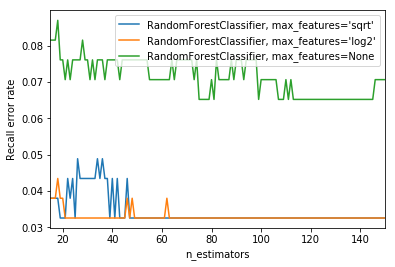

In [60]:
RANDOM_STATE = 120

import warnings
warnings.filterwarnings("ignore")
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 15
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_undersample, Y_undersample)

        y_pred = clf.predict(X_validation)
        recall = recall_score(Y_validation,y_pred)
        error = 1 - recall
        error_rate[label].append((i, error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Recall error rate")
plt.legend(loc="upper right")
plt.show()

## Evaluacion

In [61]:
clf = RandomForestClassifier(n_estimators=25,max_features= 'log2',oob_score =True)

clf.fit(X_undersample,Y_undersample.values.ravel())

clf.oob_score_

y_pred = clf.predict(df_test_X)
recall_score(df_test_Y,y_pred)

0.9653333333333334

In [62]:
confusion_matrix(df_test_Y,y_pred)


array([[14151,  1474],
       [   13,   362]], dtype=int64)

### Con este resultado tenemos 13 FNs y 1474 FPs. El costo total del modelo sera :

## (13x500) + (1474x10) = 21,240. Si comparamos con el modelo ....